In [1]:
import pandas as pd, numpy as np
import QTLfunctions as QTLfun
from sklearn import feature_selection as fs
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
## Set relative regions of MAT locus
MAT = [1529240,1661861]

In [3]:
## Bring in centromeres datarame
cent_path = '/home/croth/Downloads/B3502/DATA/FungiDB-48_CneoformansJEC21_centromeres.csv'
centlocs = pd.read_csv(cent_path,index_col=0)
centlocs.head()

,Chromosome,Left,Right
0,1,942544,993056
1,2,860449,900038
2,3,806551,906800
3,4,222000,273992
4,5,784047,849321


In [4]:
## Bring in chromosome map
chrommap_path = '/home/croth/Downloads/B3502/DATA/chrommap.csv.gz'
chrommap = pd.read_csv(chrommap_path)
chrommap['Seqid'] = chrommap.Contig
chrommap.drop('Contig',axis=1,inplace=True)
chrommap['Chromosome'] = chrommap.index+1
chrommap = chrommap.merge(centlocs)
chrommap.tail()

,Length,Cumlen,Midpts,Seqid,Chromosome,Left,Right
9,1085720,14488944,15031804.0,AE017350.1,10,807373,880180
10,1019846,15574664,16084587.0,AE017351.1,11,144778,180133
11,906719,16594510,17047869.5,AE017352.1,12,146899,171065
12,787999,17501229,17895228.5,AE017353.1,13,121986,179214
13,762694,18289228,18670575.0,AE017356.1,14,566417,639012


In [5]:
## Bring in genotype dataframe
genopath = '../GENOTYPE/B3502_progeny_variants.csv.gz'
geno = pd.read_csv(genopath,
                   index_col=0)
geno.head()

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,...,B04,B05,B06,B07,B08,B09,B10,B11,B12,B20
7713,AE017341.1,530127,87856.4,1.0,1,C.G,1,1,5440,snp,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
13742,AE017341.1,884617,51253.4,1.0,1,AGG.AGA,3,3,3444,snp,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
16507,AE017341.1,1032506,76943.9,1.0,1,T.C,1,1,5283,snp,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
22088,AE017341.1,1430787,11823.5,1.0,1,G.T,1,1,4119,snp,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25519,AE017341.1,1694543,80782.5,1.0,1,G.C,1,1,5795,snp,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [6]:
geno[(geno.Chrom==2)].shape

(475, 73)

In [7]:
geno.shape[0]

1926

In [8]:
geno.groupby('Chrom').count()['Pos'].median()

4.0

In [9]:
## Bring in phenotype data from Dr. Sheng Sun
phenopath = '../PHENOTYPE/202011_WGS_B3502Progeny_phenotypes.csv.gz'
pheno = pd.read_csv(phenopath)
pheno.index = pheno.Strain
pheno.tail()

,Cross_Progeny,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Phenotype,Strain
Strain,,,,
B09,1. B3502A1_x_CF830_Random12,N,0.0,B09
B10,1. B3502A1_x_CF830_Random14,N,0.0,B10
B11,1. B3502A1_x_CF830_Random20,T,2.0,B11
B12,2. B3502B1_x_CF830_Random01,N,0.0,B12
B20,2. B3502B1_x_CF830_Random12,Y,1.0,B20


In [10]:
## Make additional phenotype groups 
## by binning Dr Sun's scores
## Define binning dictionarys
bidict = dict(zip([0,1,2,3],[0,1,1,1]))
tridict = dict(zip([0,1,2,3],[0,1,1,2]))

## Replace scores
pheno['Binary'] = pheno.Phenotype.replace(bidict)
pheno['Tertiary'] = pheno.Phenotype.replace(tridict)

## View restuls
pheno[[pheno.columns[2],'Phenotype','Binary','Tertiary']].drop_duplicates()

,Phenotype,Phenotype,Binary,Tertiary
Strain,,,,
A01,0.0,0.0,0.0,0.0
A02,1.0,1.0,1.0,1.0
A04,3.0,3.0,1.0,2.0
A09,2.0,2.0,1.0,1.0


In [11]:
## Gather samples and unique testing sites
samples_wc = sorted(pheno.Strain.tolist())
clone_drop = ['A44','A24'] #['A27','A43']
samples = [s for s in samples_wc if s not in clone_drop]
len(samples)

55

In [12]:
## Gather unique haplotypes for testing
loci = geno[samples].drop_duplicates()
loci.shape

(59, 55)

In [13]:
## Here I have set the phenotype to a quadriaary phenotype
## Uncomment this to analyze a binary phenotype
## Filamentous vs nonfilamentous vs large cells
#pheno_label = 'Phenotype'
#pheno_label = 'Binary'
pheno_label = 'Tertiary'

## Copy loci df and append phenotype set above
usnps = loci.copy().T
Y = pheno.loc[samples,pheno_label]
usnps['Y'] = Y
usnps.shape

(55, 60)

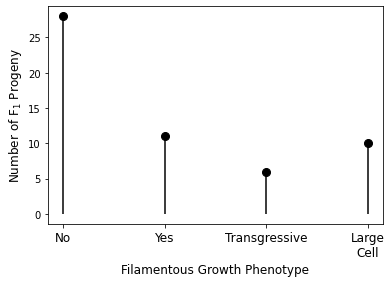

In [54]:
## Plot distribution of phenotypes
x,y = np.unique(pheno.loc[samples,'Phenotype'].values,return_counts=True)

plt.vlines(x,0,y,color='k');
plt.plot(x,y,'o',color='k',ms=8);
plt.xticks(x,['No','Yes','Transgressive','Large\nCell'],fontsize=12)
plt.xlabel('Filamentous Growth Phenotype',fontsize=12)
plt.ylabel('Number of F$_1$ Progeny',fontsize=12);
plt.savefig('../FIGURES/Filamentous_phenotypes_hist.png',
            dpi=200,bbox_inches='tight');

In [15]:
## QTL MAPPING!!!
## Single locus effect
miobs = fs.mutual_info_classif(usnps.values,usnps['Y'].values,
                               discrete_features=True)
## append as column to snp dataframe
res = usnps.T
res['MIobs'] = miobs

## Merge with genotype dataframe
res = geno.merge(res)

In [16]:
## Conduct permutations
## Establish genome-wide signfiance
thres = 0.16507851056671202
perms = []
nperm = 10000
if thres is None:
    for i in range(nperm):
    
        y = usnps['Y'].values
        permy = np.random.permutation(y) ## Permute Y
        usnps['Y'] = permy
        MIobsp = fs.mutual_info_classif(usnps.values,permy,
                               discrete_features=True)
    
        perms.append(np.max(MIobsp[:-1]))
    
        alpha = 95 if nperm  == 1000 else 99
        thres = np.percentile(perms,alpha)

In [17]:
## Plot null distribution of association
if (thres is not None) and (len(perms)==nperm):

    plt.hist(perms,alpha=0.5,color='grey');
    plt.xlabel('$I$ ( G$_n$, F )',fontsize=12);
    plt.ylabel('# of Permutations',fontsize=12);
    plt.title('Null Distribution of Association',fontsize=12);
    plt.vlines(thres,0,nperm/6,color='r',alpha=0.5);
    plt.text(thres,nperm/6,'\u03B1 = 0.01',fontsize=12,
         color='k',alpha=0.5,va='bottom',ha='center')
    plt.savefig('../FIGURES/IG_null_dist.png',
            dpi=100,bbox_inches='tight');

In [18]:
## Make chromsome plotting map
idxmap = list(np.arange(0,14,2)) + list(np.arange(0,14,2)+1)

In [19]:
## Plot a Manhattan plot
fig,ax = plt.subplots(7,2,figsize=(15,15),
                      sharex=False,sharey=False)
fig.set_facecolor('w')

centy = - 0.09
centw = 10

for i,(j,c) in enumerate(chrommap.iterrows()):
    
    plt.sca(ax.ravel()[idxmap[i]])
    plt.hlines(0,0,c.Length,color='k',
               linestyle='-',alpha=0.5)
    plt.hlines(thres,0,c.Length,color='k',
               linestyle='--',alpha=0.3)
    
    
    plt.hlines(centy,c.Left,c.Right,color='r',
               linewidth=centw,alpha=0.5)
    
    if (c.Chromosome==4):
        plt.hlines(centy,*MAT,color='g',
                   linewidth=centw,alpha=0.5)
        
    temp = res[(res.Seqid==c.Seqid)]

    plt.vlines(temp.Pos,0,temp.MIobs,color='k')
    plt.plot(temp.Pos,temp.MIobs,'k.')
    plt.text(x=0,y=1,va='center',ha='left',
             s='Chromosome %s'%(i+1),fontsize=14)
    
    xp,xl = plt.xticks()
    
    xpz = xp[1:-1] if i < 12 else xp[1:-1][1::2]
    xpz = xpz[(xpz<c.Length)]
    plt.xticks(xpz,[int(x/1000) for x in xpz],
              fontsize=12)
    
    plt.xlim(0,np.max(chrommap.Length))
    plt.ylim(centy-0.01,0.85)
    plt.yticks([0,0.25,0.5,0.75])
    
    ax.ravel()[i].spines['right'].set_visible(False)
    ax.ravel()[i].spines['top'].set_visible(False)
    ax.ravel()[i].spines['bottom'].set_visible(False)

plt.subplots_adjust(wspace=0.1,hspace=1);
fig.text(0.5,0.075,'Chromosome Coordinate (kb)',
         fontsize=16,va='center',ha='right');
fig.text(0.07,0.5,'$I$ ( G$_n$, F )',
         rotation=90,fontsize=16);

savepath = '../FIGURES/QTL_IG_B3502_%s_filamentous_growth.png'%pheno_label
plt.savefig(savepath,
           dpi=200,bbox_inches='tight');
plt.close()

im = Image.open(savepath)
im_crop = im.crop((0, 0, 2000, 2520))

im_crop.save(savepath)

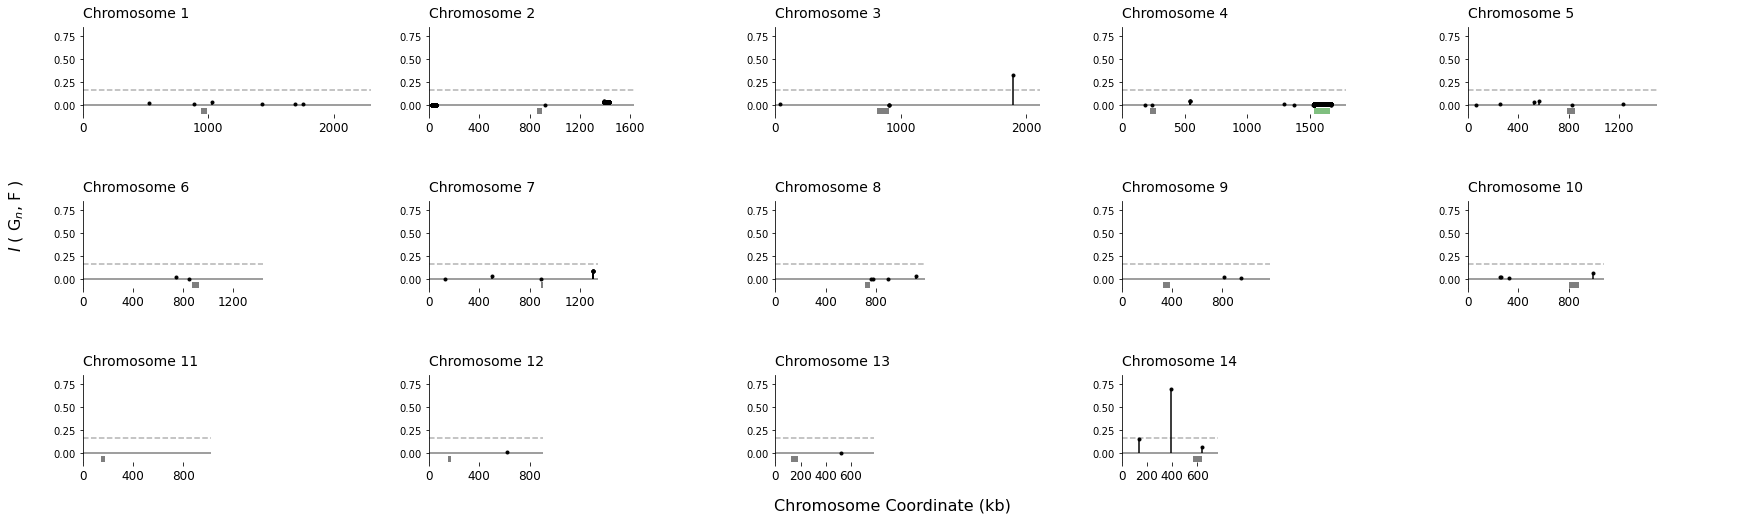

In [20]:
## Plot a Manhattan plot
fig,ax = plt.subplots(3,5,figsize=(30,8),
                      sharex=False,sharey=False)
fig.set_facecolor('w')

centy = - 0.09
centw = 10

for i,(j,c) in enumerate(chrommap.iterrows()):
    
    #plt.sca(ax.ravel()[idxmap[i]])
    plt.sca(ax.ravel()[i])
    plt.hlines(0,0,c.Length,color='k',
               linestyle='-',alpha=0.5)
    plt.hlines(thres,0,c.Length,color='k',
               linestyle='--',alpha=0.3)
    
    
    plt.hlines(centy,c.Left,c.Right,color='k',
               linewidth=centw,alpha=0.5)
    
    if (c.Chromosome==4):
        plt.hlines(centy,*MAT,color='g',
                   linewidth=centw,alpha=0.5)
        
    temp = res[(res.Seqid==c.Seqid)]

    plt.vlines(temp.Pos,0,temp.MIobs,color='k')
    plt.plot(temp.Pos,temp.MIobs,'k.')
    plt.text(x=0,y=1,va='center',ha='left',
             s='Chromosome %s'%(i+1),fontsize=14)
    
    xp,xl = plt.xticks()
    
    
    xpz = xp[1:-1][::2]
    xpz = xpz[(xpz<c.Length)]
    plt.xticks(xpz,[int(x/1000) for x in xpz],
              fontsize=12)
    
    plt.xlim(0,np.max(chrommap.Length))
    plt.ylim(centy-0.01,0.85)
    plt.yticks([0,0.25,0.5,0.75])
    
    ax.ravel()[i].spines['right'].set_visible(False)
    ax.ravel()[i].spines['top'].set_visible(False)
    ax.ravel()[i].spines['bottom'].set_visible(False)

plt.subplots_adjust(wspace=0.2,hspace=1);
fig.text(0.5,0.05,'Chromosome Coordinate (kb)',
         fontsize=16,va='center',ha='center');
fig.text(0.09,0.5,'$I$ ( G$_n$, F )',
         rotation=90,fontsize=16);
plt.sca(ax[-1,-1]);plt.axis('off');
savepath = '../FIGURES/QTL_IG_B3502_%s_filamentous_growth_long.png'%pheno_label
plt.savefig(savepath,
           dpi=200,bbox_inches='tight');
#plt.close()

#im = Image.open(savepath)
#im_crop = im.crop((0, 0, 2000, 2520))

#im_crop.save(savepath)
#im_crop

In [57]:
res

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,...,B05,B06,B07,B08,B09,B10,B11,B12,B20,MIobs
0,AE017341.1,530127,87856.4,1.0,1,C.G,1,1,5440,snp,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.020543
1,AE017341.1,884617,51253.4,1.0,1,AGG.AGA,3,3,3444,snp,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.009574
2,AE017341.1,1032506,76943.9,1.0,1,T.C,1,1,5283,snp,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.029604
3,AE017341.1,1430787,11823.5,1.0,1,G.T,1,1,4119,snp,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.012251
4,AE017341.1,1694543,80782.5,1.0,1,G.C,1,1,5795,snp,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.014392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,AE017352.1,622674,70473.3,1.0,1,C.G,1,1,4968,snp,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.015129
1922,AE017353.1,523635,74542.7,1.0,1,T.C,1,1,4392,snp,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.001358
1923,AE017356.1,134798,96426.2,1.0,1,G.C,1,1,6359,snp,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.147441
1924,AE017356.1,388780,80970.8,1.0,1,G.T,1,1,5055,snp,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.692982


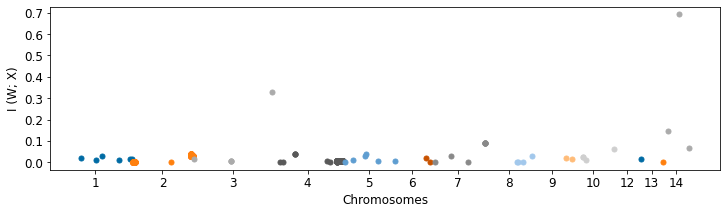

In [66]:
QTLfun.manhattan(res,pval='MIobs',ms=10,ylabel="I (W; X)");

In [21]:
## Find loci above threshold
sigloci = res[(res.MIobs>=thres)]
sigloci

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,...,B05,B06,B07,B08,B09,B10,B11,B12,B20,MIobs
485,AE017343.1,1894056,98227.7,1.0,1,G.A,1,1,5098,snp,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.328123
1924,AE017356.1,388780,80970.8,1.0,1,G.T,1,1,5055,snp,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.692982


In [22]:
## append Genotypes of QTL and MAT
pheno['RIC8'] = sigloci[(sigloci.Chrom==14)][pheno.index].values[0]
pheno['QTL3'] = sigloci[(sigloci.Chrom==3)][pheno.index].values[0]
pheno['MAT'] = geno[(geno.Chrom==4) & 
                    (geno.Pos>=np.min(MAT)) & 
                    (geno.Pos<=np.max(MAT))][pheno.index].min()

In [23]:
pheno['Ran'] = [0 if a[0]=='A' else 1 for a in pheno.Strain]

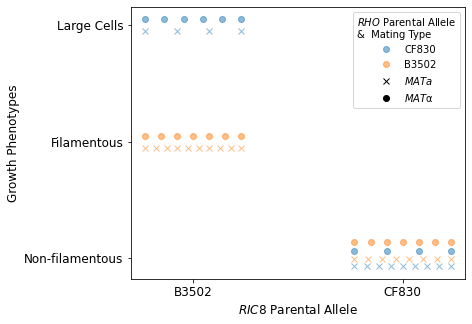

In [24]:
## Make a phenotype by genotype plot
fig,ax = plt.subplots(1,1,figsize=(6,5))
fig.set_facecolor('w')
## Set ylabels
yphenos = ['Non-filamentous','Filamentous','Large Cells']
y = pheno.loc[samples,'Tertiary'].values

## Gather QTL genotypes
## QTL14 allele
ric8 = pheno.loc[samples,'RIC8']
## QTL3 allele
rho = pheno.loc[samples,'QTL3']
## Gather MAT locus
mat = pheno.loc[samples,'MAT']
#geno[(geno.Chrom==4) & (geno.Pos>=np.min(MAT)) & 
#     (geno.Pos<=np.max(MAT))][samples].min().to_numpy()
for i in [0,1]:
    for j in [0,1]:
        for m in [0,1]:
            gix = (ric8==i) & (rho==j) & (mat == m)
        
            if (i+m == 2) and (j == 0) :
                mylabel = 'CF830'#+'$^{RHO}$'
            elif (i+m ==2) and (j == 1):
                mylabel = 'B3502'#+'$^{RHO}$'
            else:
                mylabel = None
                
            xjitter = np.linspace(-0.23,0.23,np.sum(gix)) 
            
            if (i==0):
                yjitter = np.array([-0.07,-0.01,0.06,0.14])[j+2*m]
            else:
                yjitter = np.array([-0.05,0.05])[m]
            
            plt.plot((1 - ric8[gix])+xjitter,y[gix]+yjitter,
                     'o' if m == 1 else 'x',
                     alpha= .5,label = mylabel,
                     color='tab:blue' if j == 0 else 'tab:orange')
            
plt.plot(1,1,'kx',alpha=1,label='$MATa$');
plt.plot(1,1,'ko',alpha=1,label='$MAT$'+'\u03B1');
plt.plot(1,1,'wo',ms=10)

plt.legend(loc=0,frameon=True,
           title='$RHO$ Parental Allele \n&  Mating Type')
plt.yticks(sorted(np.unique(y)),yphenos,fontsize=12)
plt.ylabel('Growth Phenotypes',fontsize=12);
plt.xticks([0,1],['B3502','CF830'],fontsize=12)
plt.xlim(-0.3,1.3);
plt.xlabel('$RIC8$ Parental Allele',fontsize=12);
plt.savefig('../FIGURES/Filamentous_by_QTL.png',
            dpi=200,bbox_inches='tight')

In [25]:
pheno[[pheno.columns[1],'Tertiary']].drop_duplicates()

,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Tertiary
Strain,,
A01,N,0.0
A02,Y,1.0
A04,L,2.0
A05,N (with rare spots of T),0.0
A09,T,1.0


In [26]:
gffpath = '/home/croth/Downloads/B3502/REF/FungiDB-48_CneoformansJEC21.gff.gz'
gff = QTLfun.loadgff(gffpath)
gff.head()

,Seqid,Source,Type,Start,End,Score,Strand,Phase,Attribute,Parent,Gene
0,AE017352.1,VEuPathDB,gene,713524,714773,.,-1,.,ID=CNL06190;description=aldo-keto reductase%2C...,CNL06190,CNL06190
1,AE017352.1,VEuPathDB,mRNA,713524,714773,.,-1,.,ID=CNL06190-t26_1;Parent=CNL06190;description=...,CNL06190,CNL06190
2,AE017352.1,VEuPathDB,exon,713524,713666,.,-1,.,ID=exon_CNL06190-E5;Parent=CNL06190-t26_1,CNL06190-t26_1,CNL06190
3,AE017352.1,VEuPathDB,exon,713720,713815,.,-1,.,ID=exon_CNL06190-E4;Parent=CNL06190-t26_1,CNL06190-t26_1,CNL06190
4,AE017352.1,VEuPathDB,exon,713866,714350,.,-1,.,ID=exon_CNL06190-E3;Parent=CNL06190-t26_1,CNL06190-t26_1,CNL06190


In [27]:
gff[(gff.Seqid==sigloci.T[485].Seqid) & 
    (gff.Start<=sigloci.T[485].Pos) & 
    (gff.End>=sigloci.T[485].Pos)]

,Seqid,Source,Type,Start,End,Score,Strand,Phase,Attribute,Parent,Gene
82135,AE017343.1,VEuPathDB,gene,1892361,1896258,.,-1,.,ID=CNC06490;description=Rho GTPase activator%2...,CNC06490,CNC06490
82136,AE017343.1,VEuPathDB,mRNA,1892361,1896258,.,-1,.,ID=CNC06490-t26_1;Parent=CNC06490;description=...,CNC06490,CNC06490
82139,AE017343.1,VEuPathDB,exon,1894041,1894217,.,-1,.,ID=exon_CNC06490-E4;Parent=CNC06490-t26_1,CNC06490-t26_1,CNC06490
82145,AE017343.1,VEuPathDB,CDS,1894041,1894217,.,-1,2,ID=CNC06490-t26_1-p1-CDS3;Parent=CNC06490-t26_...,CNC06490-t26_1,CNC06490


In [28]:
gene_changes = pd.read_csv('/home/croth/Downloads/B3502/DATA/gene_changes.csv.gz')

In [29]:
gene_changes.Strain.unique()

array(['B3502_A1_Stock1', 'B3502_A7_Stock2', 'B3502_B1_Stock3',
       'B3502_B7_Stock4', 'B3502_C1_Stock7', 'B3502_D1_Stock6', 'CF830',
       'JEC20', 'JEC21', 'B3502_C1_Stock5'], dtype=object)

In [30]:
gene_changes[(gene_changes.Gene=='CNC06490') & 
             (gene_changes.Strain.isin(
                 ['B3502_A1_Stock1',
                  'B3502_B1_Stock3',
                  'B3502_B7_Stock4',
                  'CF830']))]

,Strain,Gene,Parent,Expected,Ref,Alt,Refstop,Altstop,Nonsyn,Nvars,Utr5,Utr3,Exon,Intron,Chromosome,Seqid,Start,End,Strand,Description
365,B3502_A1_Stock1,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
367,B3502_B1_Stock3,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
368,B3502_B7_Stock4,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,1,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator
372,CF830,CNC06490,CNC06490-t26_1,996.0,996,996,1,1,0,1,0,0,1,0,3,AE017343.1,1892361,1896258,-,Rho GTPase activator


In [31]:
gff[(gff.Gene=='CNC06490') & (gff.Type=='CDS')].shape

(5, 11)

In [32]:
## How corrilated are these loci
sigloci[samples].T.corr(method='spearman')

,485,1924
485,1.000000,0.095183
1924,0.095183,1.000000


In [33]:
## how correlated is the chromosome 14 variants
res[(res.Chrom==14)][samples].T.corr()

,1923,1924,1925
1923,1.000000,0.527153,0.098801
1924,0.527153,1.000000,0.277342
1925,0.098801,0.277342,1.000000


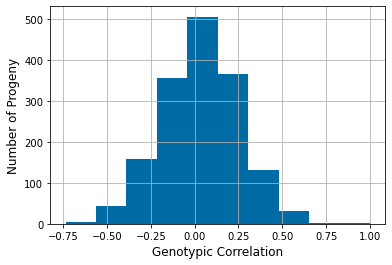

In [34]:
## Find clones
loci = geno[samples_wc].drop_duplicates()
segcors = []
for i,s1 in enumerate(samples_wc):
    for j,s2 in enumerate(samples_wc):
        
        if i>j:
            cs = loci[[s1,s2]].corr().values[0][-1]
            segcors.append((s1,s2,cs))
        else:
            pass
segcors = pd.DataFrame(segcors,columns=['S1','S2','Cor'])

## Display histogram of genetic correlations
segcors.Cor.hist();
plt.ylabel('Number of Progeny',fontsize=12)
plt.xlabel('Genotypic Correlation',fontsize=12);

In [35]:
## Find clones
clones = segcors[(segcors.Cor>.8)]
clones

,S1,S2,Cor
348,A27,A24,1.0
945,A44,A43,1.0


In [36]:
## View data of clone group 2
pheno[(pheno.Strain.isin(clones.values[1][:-1]))]

,Cross_Progeny,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Phenotype,Strain,Binary,Tertiary,RIC8,QTL3,MAT,Ran
Strain,,,,,,,,,,
A43,3. B3502B7_x_CF830_BasidiumSpecific_42,T,2.0,A43,1.0,1.0,1.0,1.0,0.0,0
A44,3. B3502B7_x_CF830_BasidiumSpecific_45,Y,1.0,A44,1.0,1.0,1.0,1.0,0.0,0


In [37]:
## Samples with transgressive filamentation
pheno[(pheno.Phenotype==2)]

,Cross_Progeny,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Phenotype,Strain,Binary,Tertiary,RIC8,QTL3,MAT,Ran
Strain,,,,,,,,,,
A09,1. B3502A1_x_CF830_BasidiumSpecific_20,T,2.0,A09,1.0,1.0,1.0,1.0,0.0,0
A27,2. B3502B1_x_CF830_BasidiumSpecific_24,T,2.0,A27,1.0,1.0,1.0,1.0,0.0,0
A37,3. B3502B7_x_CF830_BasidiumSpecific_24,T,2.0,A37,1.0,1.0,1.0,1.0,0.0,0
A43,3. B3502B7_x_CF830_BasidiumSpecific_42,T,2.0,A43,1.0,1.0,1.0,1.0,0.0,0
B07,1. B3502A1_x_CF830_Random10,T,2.0,B07,1.0,1.0,1.0,1.0,0.0,1
B11,1. B3502A1_x_CF830_Random20,T,2.0,B11,1.0,1.0,1.0,1.0,0.0,1


In [38]:
## Check phenotype of progeny with duplicated chromosome 11
pheno[(pheno.Strain=='A03')]

,Cross_Progeny,Phenotype on MS (N-no filamentation; Y-filamentation; L-giant cells; T-transgressive filamentation),Phenotype,Strain,Binary,Tertiary,RIC8,QTL3,MAT,Ran
Strain,,,,,,,,,,
A03,1. B3502A1_x_CF830_BasidiumSpecific_04,N,0.0,A03,0.0,0.0,0.0,0.0,0.0,0


In [39]:
## how many unique loci combos
((usnps.shape[1] - 1)**2 - (59))/2

1711.0

In [40]:
## Looks like there may be SNPS near or in centromeres
for i,c in chrommap.iterrows():
    temp = geno[(geno.Chromosome==c.Chromosome) & 
                (geno.Pos>=c.Left) & (geno.Pos<=c.Right)]
    if temp.shape[0]>0:
        print(temp[['Pos','Chromosome','Alleles']])
        print('\n')
    else:
        pass

          Pos  Chromosome             Alleles
84379  904246           3                 T.C
84382  904260           3               CA.TG
84384  904292           3  CTGTTGGCT.CTGTGGGT


           Pos  Chromosome Alleles
110854  243520           4     G.A


           Pos  Chromosome Alleles
154798  828016           5     G.A


           Pos  Chromosome Alleles
209605  890559           7     C.T


           Pos  Chromosome Alleles
352449  635842          14     G.A




In [41]:
## Phenotype
Y = pheno.loc[samples,'Tertiary'].values.reshape(-1,1)

## Main loci to test
ssk1 = pheno.loc[samples,'MAT'].values.reshape(-1,1)
ssk2 = pheno.loc[samples,'QTL3'].values.reshape(-1,1)
ric8 = pheno.loc[samples,'RIC8'].values.reshape(-1,1)

# encode two- and three-locus genotypes
ssk1ssk2 = ssk1 + 2 * ssk2
ssk1ric8 = ssk1 + 2 * ric8
ssk2ric8 = ssk2 + 2 * ric8
ssk1ssk2ric8 = ssk1 + 2*ssk2 + 4*ric8

MIobs = fs.mutual_info_classif(np.hstack((Y,
                                  ssk1,ssk2,ric8,
                                  ssk1ssk2, ssk1ric8, ssk2ric8,
                                  ssk1ssk2ric8)), Y.ravel(),
                      discrete_features=True)

# label MIs
MI_ssk1 = MIobs[1]
MI_ssk2 = MIobs[2]
MI_ric8 = MIobs[3]
MI_ssk1ssk2 = MIobs[4]
MI_ssk1ric8 = MIobs[5]
MI_ssk2ric8 = MIobs[6]
MI_ssk1ssk2ric8 = MIobs[7]

entropy_Y = MIobs[0]

# IGstrict of Hu et al
IG_ssk1ssk2 = MI_ssk1ssk2 - MI_ssk1 - MI_ssk2
IG_ssk1ric8 = MI_ssk1ric8 - MI_ssk1 - MI_ric8
IG_ssk2ric8 = MI_ssk2ric8 - MI_ssk2 - MI_ric8
IG_ssk1ssk2ric8 =  MI_ssk1ssk2ric8 - np.maximum(IG_ssk1ssk2, 0) \
    - np.maximum(IG_ssk1ric8,0) \
    - np.maximum(IG_ssk2ric8, 0) \
    - MI_ssk1 - MI_ssk2 - MI_ric8

In [42]:
MIperm = []

for i in range(1000):
    origgenos = np.hstack((ssk1,ssk2,ric8))
    permgenos = np.random.permutation(origgenos)
    pssk1 = permgenos[:,0]
    pssk2 = permgenos[:,1]
    pric8 = permgenos[:,2]
    pssk1 = pssk1.reshape(-1,1)
    pssk2 = pssk2.reshape(-1,1)
    pric8 = pric8.reshape(-1,1)
    pssk1ssk2 = pssk1 + 2*pssk2
    pssk1ric8 = pssk1 + 2*pric8
    pssk2ric8 = pssk2 + 2*pric8
    pssk1ssk2ric8 = pssk1 + 2*pssk2 + 4*pric8    
    
    miperm = fs.mutual_info_classif(np.hstack((Y,
                                  pssk1,pssk2,pric8)), Y.ravel(),
                      discrete_features=True)
    MIperm.append(miperm)
    
    
MIperm = np.array(MIperm)
    
MI_pssk1 = MIperm[:,1]
MI_pssk2 = MIperm[:,2]
MI_pric8 = MIperm[:,3]

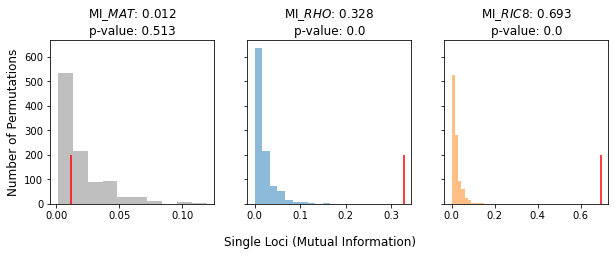

In [43]:
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
fig.set_facecolor('w')

plt.sca(ax[0])
plt.hist(MI_pssk1,color='grey',alpha=0.5)
plt.vlines(MI_ssk1, ymin=0, ymax=200, color='r')
plt.title("MI_$MAT$: %s\np-value: %s"%(
            str(np.round(MI_ssk1,3)),
            str(np.round(np.sum(MI_pssk1 > MI_ssk1)/float(len(MI_pssk1)),3))),
         fontsize=12)
plt.ylabel('Number of Permutations',fontsize=12)
      

plt.sca(ax[1])
plt.hist(MI_pssk2,color='tab:blue',alpha=0.5)
plt.vlines(MI_ssk2, ymin=0, ymax=200, color='r')
plt.title("MI_$RHO$: %s\np-value: %s"%(
            str(np.round(MI_ssk2,3)),
            str(np.round(np.sum(MI_pssk2 > MI_ssk2)/float(len(MI_pssk2)),3))),
         fontsize=12)
#print("MI_QTL3: ", MI_ssk2, "p-value: ", 
#      np.sum(MI_pssk2 > MI_ssk2)/float(len(MI_pssk2)))

plt.sca(ax[2])
plt.hist(MI_pric8,color='tab:orange',alpha=0.5)
plt.vlines(MI_ric8, ymin=0, ymax=200, color='r')
plt.title("MI_$RIC8$: %s\np-value: %s"%(
            str(np.round(MI_ric8,3)),
            str(np.round(np.sum(MI_pric8 > MI_ric8)/float(len(MI_pric8)),3))),
         fontsize=12)
#print("MI_ric8: ", MI_ric8, "p-value: ", 
#      np.sum(MI_pric8 > MI_ric8)/float(len(MI_pric8)))
fig.text(x=0.5,y=-0.05,s='Single Loci (Mutual Information)',
         fontsize=12,va='center',ha='center')
plt.savefig('../FIGURES/Filamentous_Main_effects.png',
           dpi=100,bbox_inches='tight');

In [44]:
MIperm = []

for i in range(1000):
    origgenos = np.hstack((ssk1,ssk2,ric8))
    
    p0ssk1 = np.random.permutation(ssk1[Y==0])
    p1ssk1 = np.random.permutation(ssk1[Y==1])
    p2ssk1 = np.random.permutation(ssk1[Y==2])
    pssk1 = np.hstack((p0ssk1,p1ssk1,p2ssk1))
    
    p0ssk2 = np.random.permutation(ssk2[Y==0])
    p1ssk2 = np.random.permutation(ssk2[Y==1])
    p2ssk2 = np.random.permutation(ssk2[Y==2])
    pssk2 = np.hstack((p0ssk2,p1ssk2, p2ssk2))    
    
    p0ric8 = np.random.permutation(ric8[Y==0])
    p1ric8 = np.random.permutation(ric8[Y==1]) 
    p2ric8 = np.random.permutation(ric8[Y==2])     
    pric8 = np.hstack((p0ric8,p1ric8,p2ric8)) 
    
    pY = np.array([0]*len(p0ssk1) + [1]*len(p1ssk1) + [2]*len(p2ssk1))
                     
    pY = pY.reshape(-1,1)
    pssk1 = pssk1.reshape(-1,1)
    pssk2 = pssk2.reshape(-1,1)
    pric8 = pric8.reshape(-1,1)
    
    pssk1ssk2 = pssk1 + 2*pssk2
    pssk1ric8 = pssk1 + 2*pric8
    pssk2ric8 = pssk2 + 2*pric8
    pssk1ssk2ric8 = pssk1 + 2*pssk2 + 4*pric8    
    
    miperm = fs.mutual_info_classif(np.hstack((pY,
                                  pssk1, pssk2, pric8,
                                  pssk1ssk2, pssk1ric8, pssk2ric8,
                                  pssk1ssk2ric8)), pY.ravel(),
                      discrete_features=True)
    MIperm.append(miperm)
    
MIperm = np.array(MIperm)
    
MI_pssk1 = MIperm[:,1]
MI_pssk2 = MIperm[:,2]
MI_pric8 = MIperm[:,3]
MI_pssk1ssk2 = MIperm[:,4]
MI_pssk1ric8 = MIperm[:,5]
MI_pssk2ric8 = MIperm[:,6]
MI_pssk1ssk2ric8 = MIperm[:,7]

zeros = np.zeros_like(MI_pssk1)

# IGstrict for permuted data
IG_pssk1ssk2 = MI_pssk1ssk2 - MI_pssk1 - MI_pssk2
IG_pssk1ric8 = MI_pssk1ric8 - MI_pssk1 - MI_pric8
IG_pssk2ric8 = MI_pssk2ric8 - MI_pssk2 - MI_pric8
IG_pssk1ssk2ric8 =  MI_pssk1ssk2ric8 - np.maximum(IG_pssk1ssk2, zeros) \
    - np.maximum(IG_pssk1ric8, zeros) \
    - np.maximum(IG_pssk2ric8, zeros) \
    - MI_pssk1 - MI_pssk2 - MI_pric8


In [45]:
np.min(IG_pssk2ric8)

-0.004539274676925498

In [46]:
IG_ssk2ric8

-0.004539274676925498

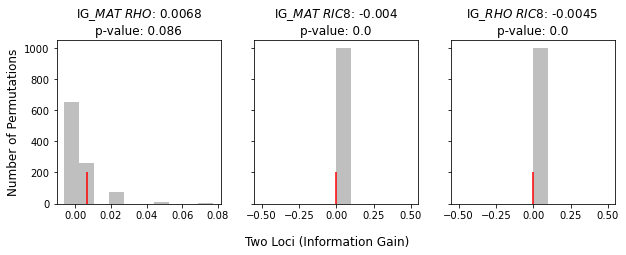

In [47]:
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
fig.set_facecolor('w')

plt.sca(ax[0])
plt.hist(IG_pssk1ssk2,color='grey',alpha=0.5)
plt.vlines(IG_ssk1ssk2, ymin=0, ymax=200, color='r')
plt.ylabel('Number of Permutations',fontsize=12)
k = np.sum(IG_pssk1ssk2 > IG_ssk1ssk2)/float(len(IG_pssk1ssk2))
plt.title("IG_$MAT$ $RHO$: %s\np-value: %s"%(
    str(np.round(IG_ssk1ssk2,4)),
    str(np.round(k,4))),fontsize=12)

#print("IG_MATQTL3: ", IG_ssk1ssk2, "p-value: ", 
#      np.sum(IG_pssk1ssk2 > IG_ssk1ssk2)/float(len(IG_pssk1ssk2)))

plt.sca(ax[1])
plt.hist(IG_pssk1ric8,color='grey',alpha=0.5)
plt.vlines(IG_ssk1ric8, ymin=0, ymax=200, color='r')
k = np.sum(IG_pssk1ric8 > IG_ssk1ric8)/float(len(IG_pssk1ric8))
plt.title("IG_$MAT$ $RIC8$: %s\np-value: %s"%(
    str(np.round(IG_ssk1ric8,4)),
    str(np.round(k,4))),fontsize=12)
#print("IG_MATric8: ", IG_ssk1ric8, "p-value: ", 
#      np.sum(IG_pssk1ric8 > IG_ssk1ric8)/float(len(IG_pssk1ric8)))

plt.sca(ax[2])
plt.hist(IG_pssk2ric8,color='grey',alpha=0.5)
plt.vlines(IG_ssk2ric8, ymin=0, ymax=200, color='r')
k = np.sum(IG_pssk2ric8 > IG_ssk2ric8)/float(len(IG_pssk2ric8))
plt.title("IG_$RHO$ $RIC8$: %s\np-value: %s"%(
    str(np.round(IG_ssk2ric8,4)),
    str(np.round(k,4))),fontsize=12)

#print("IG_QTL3ric8: ", IG_ssk2ric8, "p-value: ", 
#      np.sum(IG_pssk2ric8 > IG_ssk2ric8)/float(len(IG_pssk2ric8)))

fig.text(x=0.5,y=-0.05,s='Two Loci (Information Gain)',
         fontsize=12,va='center',ha='center')
plt.savefig('../FIGURES/Filamentous_Epistatic_effects.png',
           dpi=100,bbox_inches='tight');

IG_MATQTL3ric8:  -0.023461362501550287 p-value:  0.685


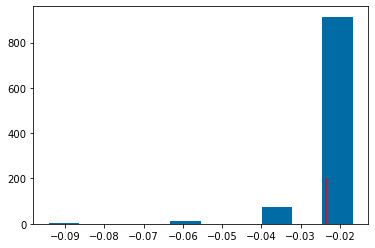

In [48]:
plt.hist(IG_pssk1ssk2ric8)
plt.vlines(IG_ssk1ssk2ric8, ymin=0, ymax=200, color='r')
print("IG_MATQTL3ric8: ", IG_ssk1ssk2ric8, "p-value: ", 
      np.sum(IG_pssk1ssk2ric8 > IG_ssk1ssk2ric8)/float(len(IG_pssk1ssk2ric8)))
pass

## Phenotype
Y = pheno.loc[samples,'Tertiary'].values.reshape(-1,1)

## Main loci to test
mat = pheno.loc[samples,'MAT'].values.reshape(-1,1)
qtl3 = pheno.loc[samples,'QTL3'].values.reshape(-1,1)
ric8 = pheno.loc[samples,'RIC8'].values.reshape(-1,1)

## Secondary effects
qtl3mat = qtl3 + 2*mat
matric8 = mat + 2*ric8
qtl3ric8 = qtl3 + 2*ric8

## Three way epistasis
matqtl3ric8 = mat + 2*qtl3 + 4*ric8

MIobs = fs.mutual_info_classif(np.hstack((Y,
                                  qtl3,mat,ric8,
                                  qtl3mat,matric8,qtl3ric8,
                                  matqtl3ric8)), Y.ravel(),
                                  discrete_features=True)

# label MIs
entropy_y = MIobs[0]

MI_qtl3 = MIobs[1]
MI_mat = MIobs[2]
MI_ric8 = MIobs[3]

MI_qtl3mat = MIobs[4]
MI_matric8 = MIobs[5]
MI_qtl3ric8 = MIobs[6]

MI_matqtl3ric8 = MIobs[7]

# IGstrict of Hu et al
IG_qtl3mat = MI_qtl3mat - MI_qtl3 - MI_mat
IG_matric8 = MI_matric8 - MI_mat - MI_ric8
IG_qtl3ric8 = MI_qtl3ric8 - MI_qtl3 - MI_ric8
IG_matqtl3ric8 =  MI_matqtl3ric8 - np.maximum(IG_qtl3mat, 0) \
    - np.maximum(IG_matric8,0) \
    - np.maximum(IG_qtl3ric8, 0) \
    - MI_qtl3 - MI_mat - MI_ric8